# Read in the data

In [2]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Intro

* Set up matplotlib to work in Jupyter notebook.
* There are several fields in combined that originally came from a survey of parents, teachers, and students. Make a bar plot of the correlations between these fields and sat_score.
 * You can find a list of the fields in the survey_fields variable in the notebook.
* Consult the data dictionary that's part of the zip file you can download from the City of New York's website.
 * Did you find any surprising correlations?
* Write up your results in a Markdown cell.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
survey_fields

['DBN',
 'rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_10',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

In [13]:
combined[survey_fields].head()

,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_10,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M292,89.0,70,39,379.000000,26.0,151.0,7.8,7.7,7.4,...,0.0,6.5,6.000000,5.600000,6.100000,6.700000,6.7,6.2,6.6,7.0
1,01M448,84.0,95,10,385.000000,37.0,46.0,7.9,7.4,7.2,...,0.0,7.3,6.000000,5.700000,6.300000,7.000000,6.8,6.3,6.7,7.2
2,01M450,0.0,98,28,598.208333,42.0,150.0,8.7,8.2,8.1,...,0.0,8.8,6.611667,6.094722,6.620278,7.381389,7.9,7.9,7.9,8.4
3,01M509,90.0,100,21,306.000000,29.0,69.0,7.7,7.4,7.2,...,0.0,6.8,6.400000,5.900000,6.400000,7.000000,6.9,6.2,6.6,7.0
4,01M539,98.0,68,51,923.000000,67.0,736.0,8.5,7.9,7.9,...,0.0,7.3,7.300000,6.400000,7.000000,7.700000,7.8,6.7,6.9,7.8


In [14]:
survey_correlations = combined[survey_fields + ["sat_score"]].corr()

In [15]:
survey_correlations["sat_score"].sort_values()

com_p_11     -0.115073
rr_t         -0.023386
eng_p_11      0.020254
aca_p_11      0.035155
rr_p          0.047925
com_tot_11    0.077310
com_t_11      0.082419
eng_tot_11    0.100102
saf_p_11      0.122913
aca_t_11      0.132348
com_s_11      0.187370
aca_tot_11    0.190966
eng_s_11      0.213822
rr_s          0.232199
N_t           0.291463
saf_t_11      0.313810
saf_tot_11    0.318753
saf_s_11      0.337639
aca_s_11      0.339435
N_p           0.421530
N_s           0.423463
sat_score     1.000000
eng_t_10           NaN
Name: sat_score, dtype: float64

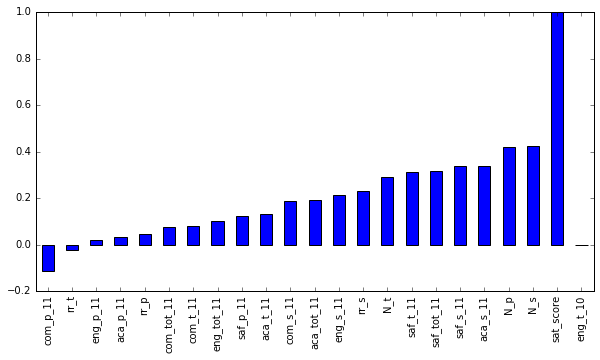

In [34]:
survey_correlations["sat_score"].sort_values().plot.bar(figsize=(10,5))
plt.show()

# Survey Correlation Notes

* The number of student `N_s` and parent `N_p` respondents showed the strongest positive correlation with SAT scores. This reinforces the findings seen in earlier exercises with this dataset, where larger schools indicated better SAT scores. 
 * An additional factor could be that survey participation from students and parents reflects a general level of engagement in academics, which would intuitively correspond to higher test scores. 
 * This can be tested by calculating the survey participation rate per school amongst students, `combined["N_s"] / combined["total_enrollment"]`

In [16]:
combined["survey_student_particpation_rate"] = \
    combined["N_s"] / combined["total_enrollment"]

In [17]:
combined["survey_student_particpation_rate"] = \
    combined["survey_student_particpation_rate"].apply(
        lambda x: x if x < 1.0 else 1.0)

In [18]:
combined["survey_student_particpation_rate"].max()

1.0

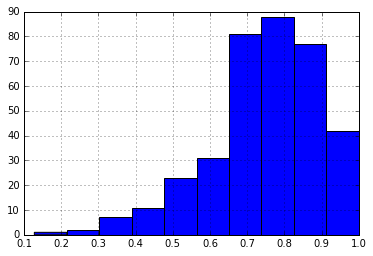

In [19]:
# survey student participation rate distribution

combined["survey_student_particpation_rate"].hist()

In [20]:
survey_participation_correlation = \
    combined[["survey_student_particpation_rate", "sat_score"]].corr()

In [21]:
survey_participation_correlation["sat_score"]

survey_student_particpation_rate    0.237585
sat_score                           1.000000
Name: sat_score, dtype: float64

# Survey Correlation Notes 2

* The survey participation rate amongst students is weakly correlated with SAT scores, but with an r value of 0.23, it's more corrlated 
than other factors like `aca_tot_11`, the Academic Expectations total score.
 * Also, after calculating this, I realized that `rr_s` holds the same information and is also correlated with SAT scores with a 0.23 r value.
* Another interesting trend is that the parent scores tend to have lower, even negative correlations, with SAT scores. 
 * For example, the `com_p_11` column, which is the Communication score based on parent responses, shows a weak negative correlation of -0.12. 
 * Perhaps parents are more critical of schools, in general, than teachers or students? And this tendency could become stronger with parents that are more actively engaged with academics, which would tend to be representated in schools with higher SAT score achievement. 
 * It would be interesting to find data about the number of students enrolled in outside SAT prep courses per school to help explain or counter this theory. 

# Investigate Safety Scores

* Investigate safety scores.
 * Make a scatter plot of the `saf_s_11` column vs. the `sat_score` in `combined`.
 * Write up your conclusions about safety and SAT scores in a Markdown cell.


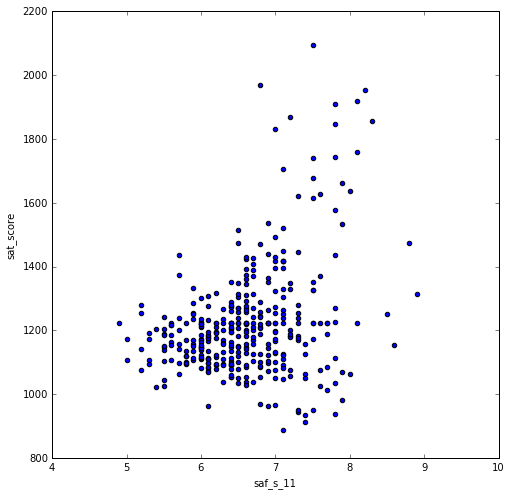

In [41]:
combined.plot.scatter(x="saf_s_11", y="sat_score", figsize=(8, 8))
plt.show()

# Safety Scores Notes

* There is a large cluster of schools that have safety scores from students below 7 and SAT scores below 1400.
 * Perhaps when safety is a risk, students may be preoccupied by that risk and less focused on learning?
 * Perhaps this reflects geography / neighborhoods? Safer neighborhoods tend to be more affluent, and I bet affluence correlates with higher test scores as well.

# Map out safety scores
 * Compute the average safety score for each district.
 * Make a map that shows safety scores by district.
 * Write up your conclusions about safety by geographic area in a Markdown cell. You may want to read up on the boroughs of New York City.

In [23]:
import numpy as np

districts = combined.groupby("school_dist").agg(np.mean)

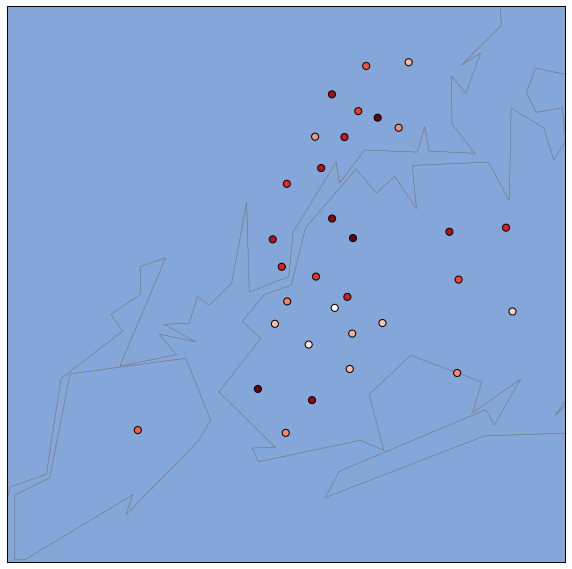

In [30]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(10,10))

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(x=longitudes, y=latitudes, s=50, zorder=2, latlon=True, 
          c=districts["saf_s_11"], cmap="Reds")

plt.show()

# Safety Score Notes 2

* Based on the map, we can see that districts that contain less affluent / higher crime neightborhoods, such as East New York, have lower student safety scores.
* Conversely, districts in Manhattan and Queens that contain relatively more affluent / lower crime neighborhoods have higher student safety scores.

# Racial Differences

There are a few columns that indicate the percentage of each race at a given school:

* white_per
* asian_per
* black_per
* hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.


# Investigate racial differences in SAT scores.

* Make a bar plot of the correlations between the columns above and sat_score.
* Write up a Markdown cell containing your findings. Are there any unexpected correlations?


In [37]:
race_columns = ["white_per", "asian_per", "black_per", "hispanic_per"]
race_correlations = combined[race_columns + ["sat_score"]].corr()

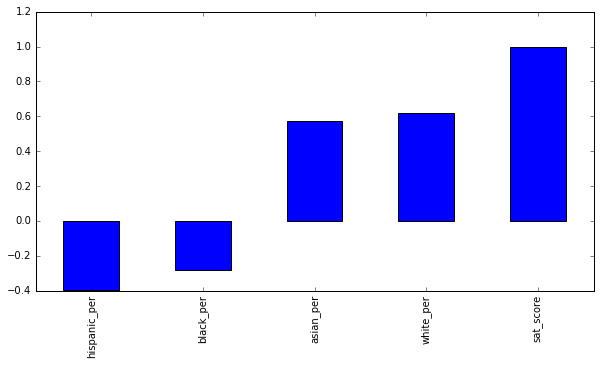

In [38]:
race_correlations["sat_score"].sort_values().plot.bar(figsize=(10,5))
plt.show()

# Race correlation notes

* As expected, schools with higher percentages of whites are correlated with higher SAT scores
 * This effect is stronger than others investigated above, such as student safety
* As expected, `black_per` and `hispanic_per` are negatively correlated with SAT scores.
 * Perhaps less expected is that `hispanic_per` is more negatively correlated than `black_per` 

# Explore schools with low SAT scores and high values for hispanic_per.

* Make a scatter plot of hispanic_per vs. sat_score.
* What does the scatter plot show? Record any interesting observsations in a Markdown cell.

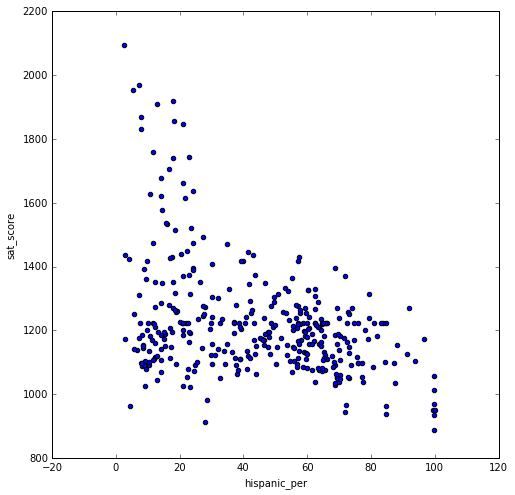

In [42]:
combined.plot.scatter(x="hispanic_per", y="sat_score", figsize=(8, 8))
plt.show()

# Notes on hispanic_per scatter plot

* It appears that there are two groups of outliers that explain the correlation: 
    * a group of schools with < 25% hispanic students and SAT scores > 1400
    * a group of schools with nearly 100% hispanic studens and SAT scores < 1100

# Research any schools with a hispanic_per greater than 95%.

* Find the school names in the data.
* Use Wikipedia and Google to research the schools by name.
* Is there anything interesting about these particular schools? Record your findings in a Markdown cell.

In [48]:
h = combined[combined["hispanic_per"] > 95].sort_values("hispanic_per", ascending=False)
h["SCHOOL NAME"]

286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
44                         MANHATTAN BRIDGES HIGH SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
Name: SCHOOL NAME, dtype: object

# hispanic_per > 95% notes

* It appears that many of these schools specialize in teaching new immigrants that are English Language Learners (ELL)


# Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800.
* Find the school names in the data.
* Use Wikipedia and Google to research the schools by name.
* Is there anything interesting about these particular schools? Record your findings in a Markdown cell.

In [49]:
h2 = combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)].sort_values("sat_score")
h2["SCHOOL NAME"]

187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
37                                STUYVESANT HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

# hispanic_per < 10% and SAT score > 1800 notes
* It appears that these are specialized high schools that are very selective
* They also appear to focus on science and technology
* These schools require students to take an exam that is similar to the SAT before admissions in 9th grade called the SHSAT: http://schools.nyc.gov/Accountability/resources/testing/SHSAT.htm


# Gender differences

There are two columns that indicate the percentage of each gender at a school:

* male_per
* female_per

We can plot out the correlations between each percentage and sat_score.

# Investigate gender differences in SAT scores.
* Make a bar plot of the correlations between the columns above and sat_score.
* Record your findings in a Markdown cell. Are there any unexpected correlations?

In [51]:
gender_columns = ["male_per", "female_per"]
gender_correlations = combined[gender_columns + ["sat_score"]].corr()

In [54]:
gender_correlations["sat_score"]

male_per     -0.112062
female_per    0.112108
sat_score     1.000000
Name: sat_score, dtype: float64

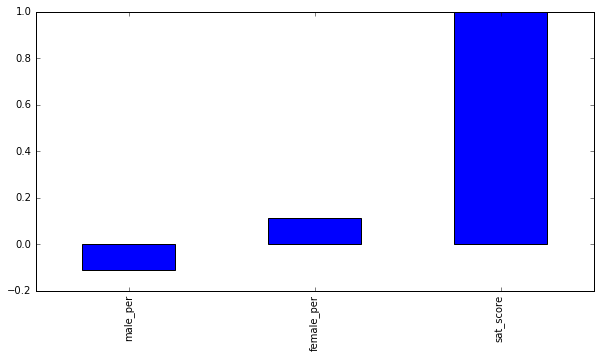

In [53]:
gender_correlations["sat_score"].plot.bar(figsize=(10, 5))
plt.show()

# Gender differences notes

* Schools with larger female populations have somewhat better SAT scores (positive r = 0.11)
* `male_per` correlation is negative (r = -0.11)
* It makes sense that these are opposite since only 2 genders are recorded

# Investigate schools with high SAT scores and a high female_per.
* Make a scatter plot of female_per vs. sat_score.
* What does the scatter plot show? Record any interesting observations in a Markdown cell.

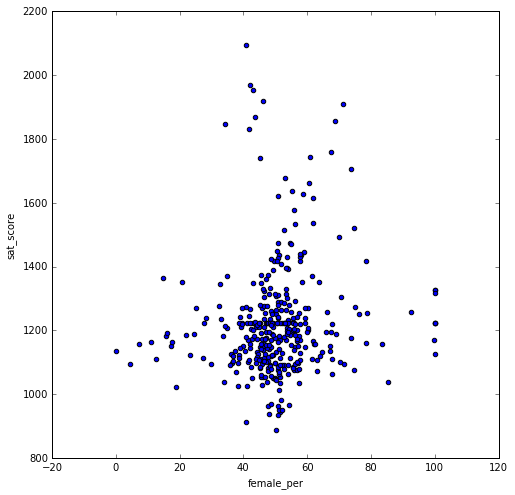

In [56]:
combined.plot.scatter(x="female_per", y="sat_score", figsize=(8, 8))
plt.show()

# Gender scatter plot notes

* The majority of schools are near 50% male, 50% female
* There are a group of schools with female percentage > 60% and relatively high SAT scores above 1400
* The schools with the highest SAT scores are around 40% female

# Research any schools with a female_per greater than 60% and an average SAT score greater than 1700.
* Find the school names in the data.
* Use Wikipedia and Google to research the schools by name.
* Is there anything interesting about these particular schools? Record your findings in a Markdown cell.


In [59]:
f = combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)].sort_values("sat_score", ascending=False)
f[["SCHOOL NAME", "female_per", "sat_score"]]

,SCHOOL NAME,female_per,sat_score
302,TOWNSEND HARRIS HIGH SCHOOL,71.1,1910.0
5,BARD HIGH SCHOOL EARLY COLLEGE,68.7,1856.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,67.5,1758.0
60,BEACON HIGH SCHOOL,61.0,1744.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,73.6,1707.0


# High performing majority female school notes

* TOWNSEND HARRIS has a storied past, having been originally the introductory year for the City College of NY. It has highly competitive admissions: http://www.thhs.qc.edu/apps/pages/index.jsp?uREC_ID=93575&type=d&termREC_ID=&pREC_ID=175320&hideMenu=1
* BARD HIGH SCHOOL EARLY COLLEGE has a program where 11th and 12th grade students do mostly college-level work (a lot of APs)
* ELEANOR ROOSEVELT and BEACON HIGH are similarly focused on AP and have competitive admissions
* LaGuardia is a performing arts focused school
* One interesting thing is none of these are "science" or "technology" schools

# AP Analysis

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

* Calculate the percentage of students in each school that took an AP exam.
  * Divide the `AP Test Takers ` column by the `total_enrollment` column.
    * The column name `AP Test Takers ` has a space at the end -- don't forget to add it!
  * Assign the result to the `ap_per` column.
* Investigate the relationship between AP scores and SAT scores.
  * Make a scatter plot of `ap_per` vs. `sat_score`.
  * What does the scatter plot show? Record any interesting observations in a Markdown cell.

In [60]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

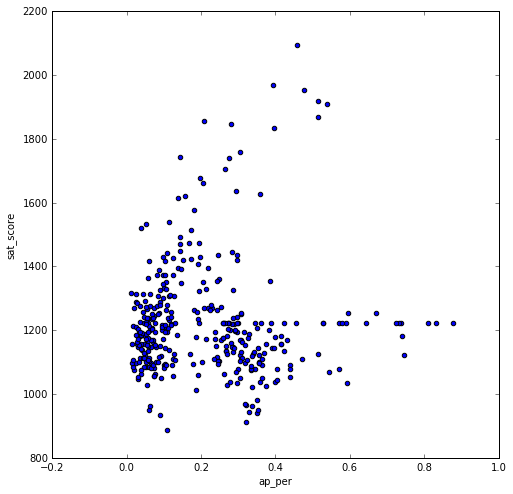

In [61]:
combined.plot.scatter(x="ap_per", y="sat_score", figsize=(8, 8))
plt.show()

# AP Analysis Notes

* There is a group of schools that has relatively high `ap_per` > 0.4 and high SAT scores above 1800.
* There is also an interesting nearly horizontal line just above SAT score 1200. This could be coincidental but it looks like perhaps an artifact of taking the mean. 